# Common Analysis
The aim of this analysis is to comprehensively assess the implications of wildfires on Lawton, OK. The notebook incorporates several key stages, including the acquisition of wildfire data from the USGS website, the computation of the distances between each wildfire within a 1250-mile radius of the city, and the generation of a comprehensive smoke estimation for the last 50 years. Subsequently, the smoke estimation will be compared and analyzed alongside the annual Air Quality Index (AQI) data sourced from a separate notebook. Finally, the analysis will culminate in the development of a robust prediction model designed to forecast the future smoke impact (smoke estimate) for the upcoming 25 years.

### License
This code example was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.0 - August 13, 2023

### Preliminaries
First we start with some imports and some constant definitions.

In [3]:
#
#    IMPORTS
# 

import os, json, time
#
#    The module pyproj is a standard module that can be installed using pip or your other favorite
#    installation tool. This module provides tools to convert between different geodesic coordinate systems
#    and for calculating distances between points (coordinates) in a specific geodesic system.
#
from pyproj import Transformer, Geod
#
#    The 'wildfire' module is a user module. This module is available from the course website. The module
#    includes one object, a Reader, that can be used to read the GeoJSON files associated with the
#    wildefire dataset. The module also contains a sample datafile that is GeoJSON compliant and that
#    contains a small number of California wildfires extracted from the main wildfire dataset.
#    
from wildfire.Reader import Reader as WFReader
#
#    There is a GeoJSON reader that you might try if you wanted to read the data. It has its own quirks.
#    There will be an example below that reads the sample file "Wildfire_short_sample.json"
#    
import geojson

import pandas as pd

import csv

In [2]:
#
#    CONSTANTS
#
FILENAME = "C:/Users/april/Documents/Documents/MSDS/DATA512/Project/USGS_Wildland_Fire_Combined_Dataset.json"

CITY_LOCATIONS = {
    'Lawton' :     {'city'   : 'Lawton',
                       'latlon' : [34.6036, -98.3959] }}


## Load the wildfire data using the geojson module

In this example we use the GeoJSON module ([documentation](https://pypi.org/project/geojson/), [GitHub repo](https://github.com/jazzband/geojson)) to load the sample file. This module works mostly the way you would expect. GeoJSON is mostly just JSON, so actually, you don't even really need to use the GeoJSON module. However, that module will do some conversion of Geo type things to something useful. However, this example, and the examples that follow, do not rely on specific Geo features from geojson.


In [3]:
#
#    Open a file, load it with the geojson loader

print(f"Attempting to open '{FILENAME}'")
geojson_file = open(FILENAME,"r")
print(f"Using GeoJSON module to load sample file '{FILENAME}'")
gj_data = geojson.load(geojson_file)
geojson_file.close()
#
#    Print the keys from the object
#
gj_keys = list(gj_data.keys())
print("The loaded JSON dictionary has the following keys:")
print(gj_keys)
print()


Attempting to open 'C:/Users/april/Documents/Documents/MSDS/DATA512/Project/USGS_Wildland_Fire_Combined_Dataset.json'
Using GeoJSON module to load sample file 'C:/Users/april/Documents/Documents/MSDS/DATA512/Project/USGS_Wildland_Fire_Combined_Dataset.json'
The loaded JSON dictionary has the following keys:
['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields', 'features']



In [43]:
filtered_features = [feature for feature in gj_data['features'] if feature['attributes']['Fire_Year'] > 1963]

df = pd.DataFrame(filtered_features)

df.head()

,attributes,geometry
0,"{'OBJECTID': 14600, 'USGS_Assigned_ID': 14600,...","{'rings': [[[-2028828.8994999994, -380860.0911..."
1,"{'OBJECTID': 14601, 'USGS_Assigned_ID': 14601,...","{'rings': [[[-2158514.0478000008, 147653.01229..."
2,"{'OBJECTID': 14602, 'USGS_Assigned_ID': 14602,...","{'rings': [[[-1864898.1349, -453547.7751000002..."
3,"{'OBJECTID': 14603, 'USGS_Assigned_ID': 14603,...","{'rings': [[[-2116931.482000001, 378000.057000..."
4,"{'OBJECTID': 14604, 'USGS_Assigned_ID': 14604,...","{'rings': [[[-2225865.2282999996, 369076.04010..."


In [74]:
gj_feature = df['attributes']
print(len(gj_feature))

117191


In [67]:
# Get the geometry for the feature we pulled from the feature_list
gj_geometry = df['geometry']
# The largest shape (ring) is supposed to be item zero in the list of 'rings'
gj_bigest_ring = [] 
for i in range(0,len(gj_geometry)):
    if 'rings' in gj_geometry[i]:
        ring =  gj_geometry[i]['rings'][0]
    else:
        ring = 'NULL'
    gj_bigest_ring.append(ring)
    
print(len(gj_bigest_ring))

null_indices = [index for index, value in enumerate(gj_bigest_ring) if value == "NULL"]
print(null_indices)

117191
[91887, 92506, 92921, 93713, 94058, 94179, 94692, 94697, 95693, 95947, 96020, 96048, 96087, 96591, 96604, 97911, 98256, 98517, 99368, 101864, 101899, 102033, 102264, 102494, 102713, 102960, 103025, 103292, 104546, 104813, 106043, 106817, 107328, 108027, 109774]


In [75]:
# Removing NULL values for curvedRings in geometry
gj_bigest_ring = [item for item in gj_bigest_ring if item != "NULL"]

print(len(gj_bigest_ring))

#Remving corresponding values in gj_feature
indices_to_drop = [91887, 92506, 92921, 93713, 94058, 94179, 94692, 94697,
                   95693, 95947, 96020, 96048, 96087, 96591, 96604, 97911, 
                   98256, 98517, 99368, 101864, 101899, 102033, 102264, 102494, 
                   102713, 102960, 103025, 103292, 104546, 104813, 106043, 106817, 107328, 108027, 109774]

indices_to_drop.sort(reverse=True)

for index in indices_to_drop:
    del gj_feature[index]

print(len(gj_feature))


117156
117156


##  Convert points between geodetic coordinate systems

Following code will take the geometry of a fire feature, extract the largest ring (i.e., the largest boundary of the fire) and convert all of the points in that ring from the ESRI:102008 coordinate system to EPSG:4326 coordinates.


In [7]:
#
#    Transform feature geometry data
#
#    The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
#    The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

In [76]:
#
#   Convert one ring from the default to EPSG
        
from tqdm import tqdm

ring_in_epsg4326_list = []
    
for ring in tqdm(gj_bigest_ring, desc="Converting", unit=" rings"):
    ring_in_epsg4326 = convert_ring_to_epsg4326(ring) 
    ring_in_epsg4326_list.append(ring_in_epsg4326)



Converting: 100%|████████████████████████████████████████████████████████| 117156/117156 [1:36:00<00:00, 20.34 rings/s]


In [84]:
csv_file = 'converted_ring.csv'

with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(ring_in_epsg4326_list)

## Compute distance between a place and a wildfire

Calculates the average distance of all perimeter points to the city (place) and returns that average as the distance. This is not quite what the centroid would be, but it is probably fairly close.


In [101]:
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns the average miles from boundary to the place
#
def average_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = ring_data  
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    # create a list to store our results
    distances_in_meters = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        distances_in_meters.append(d[2])
   
    # convert meters to miles
    distances_in_miles = [meters*0.00062137 for meters in distances_in_meters]
    # the esri polygon shape (the ring) requires that the first and last coordinates be identical to 'close the region
    # we remove one of them so that we don't bias our average by having two of the same point
    distances_in_miles_no_dup = distances_in_miles[1:]
    # now, average miles
    average = sum(distances_in_miles_no_dup)/len(distances_in_miles_no_dup)
    return average



In [106]:
#    Get a city from our CITY_LOCATIONS constant as our starting position
place = [34.6036, -98.3959]

distances = []
    
for i in tqdm(range(0,len(ring_in_epsg4326_list))):
    ave_distance = average_distance_from_place_to_fire_perimeter(place,ring_in_epsg4326_list[i])
    distances.append(ave_distance)


100%|████████████████████████████████████████████████████████████████████████| 117156/117156 [01:10<00:00, 1661.73it/s]


In [112]:
data = [item for item in gj_feature]
df_attribute = pd.DataFrame(data)
print(df_attribute.head())

   OBJECTID  USGS_Assigned_ID Assigned_Fire_Type  Fire_Year  \
0     14600             14600           Wildfire       1964   
1     14601             14601           Wildfire       1964   
2     14602             14602           Wildfire       1964   
3     14603             14603           Wildfire       1964   
4     14604             14604           Wildfire       1964   

   Fire_Polygon_Tier Fire_Attribute_Tiers     GIS_Acres  GIS_Hectares  \
0                  1         1 (1), 3 (3)  65338.877636  26441.705659   
1                  1  1 (2), 3 (3), 5 (1)  55960.694158  22646.489455   
2                  1         1 (2), 3 (3)  19218.105903   7777.291530   
3                  1         1 (2), 3 (3)  18712.494746   7572.677954   
4                  1         1 (4), 3 (6)  16887.001024   6833.926855   

                                     Source_Datasets  \
0  Comb_National_NIFC_Interagency_Fire_Perimeter_...   
1  Comb_National_NIFC_Interagency_Fire_Perimeter_...   
2  Comb_Nation

In [113]:
columns_to_keep = ['Fire_Year', 'GIS_Acres']  

df_attribute = df_attribute[columns_to_keep]

In [114]:
df_attribute.shape

(117156, 2)

In [119]:
df_distance = pd.DataFrame(distances, columns=['Distance'])

combined_df = pd.concat([df_attribute, df_distance], axis=1)

In [120]:
final_df = combined_df[combined_df['Distance'] <= 1250]

In [123]:
print(final_df.shape)
final_df.head()

(88717, 3)


,Fire_Year,GIS_Acres,Distance
0,1964,65338.877636,1209.999515
2,1964,19218.105903,1085.994951
5,1964,14101.443662,675.192860
6,1964,11365.328284,1142.017477
7,1964,11131.171732,1063.369261


In [126]:
final_df.to_csv('wild_fire_data.csv', index=False)

## Create fire smoke estimates

In [4]:
smoke_est_df=pd.read_csv('wild_fire_data.csv')

The smoke estimate considers factors such as distance, acres burned, and the year of occurrence. Notably, a larger number of acres burned contributes to an increase in the smoke estimate score, while greater distances lead to a decrease in the smoke estimate score. Additionally, the estimate reduces the smoke estimate score for wildfires that occurred a long time ago.

In [5]:
smoke_est_df['smoke est'] = smoke_est_df['GIS_Acres']*0.5 + smoke_est_df['Distance']*(-0.5)
smoke_est_df['smoke est'] -= (2023 - smoke_est_df['Fire_Year'])*20
smoke_est_df.tail(10)

,Fire_Year,GIS_Acres,Distance,smoke est
88707,2020,41.871856,1247.496900,-662.812522
88708,2020,24.718981,906.982697,-501.131858
88709,2020,21.264195,1247.131201,-672.933503
88710,2020,20.327632,1230.053129,-664.862748
88711,2020,16.737098,1235.352392,-669.307647
88712,2020,60.879054,1231.107734,-645.114340
88713,2020,14.545208,1228.672539,-667.063665
88714,2020,7.050837,1233.183553,-673.066358
88715,2020,9.342668,1232.945876,-671.801604
88716,2020,0.996962,705.226231,-412.114634


The smoke estimate above has negative values for wildfires that have smaller impact, ie far away from the city. I decided to re-scale them to avoid errors.

In [6]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 5000))

smoke_est_df['scaled_smoke_est'] = scaler.fit_transform(smoke_est_df[['smoke est']].values)

print(smoke_est_df.head())


   Fire_Year     GIS_Acres     Distance     smoke est  scaled_smoke_est
0       1964  65338.877636  1209.999515  30884.439060        208.179756
1       1964  19218.105903  1085.994951   7886.055476         61.612943
2       1964  14101.443662   675.192860   5533.125401         46.617913
3       1964  11365.328284  1142.017477   3931.655404         36.411876
4       1964  11131.171732  1063.369261   3853.901235         35.916355


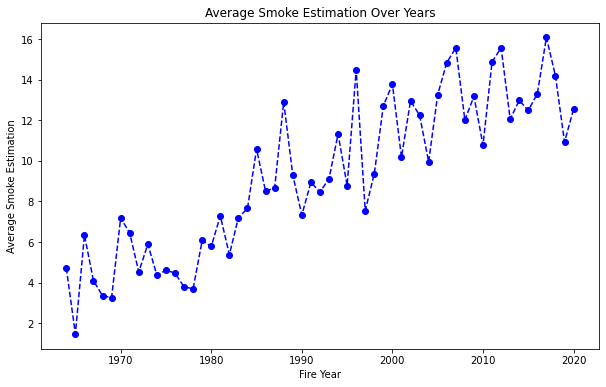

In [17]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
# Calculate the average smoke est over each year
average_smoke_est = smoke_est_df.groupby('Fire_Year')['scaled_smoke_est'].mean()

plt.figure(figsize=(10, 6))
plt.plot(average_smoke_est.index, average_smoke_est.values, marker='o', linestyle='--', color='b')

plt.title('Average Smoke Estimation Over Years')
plt.xlabel('Fire Year')
plt.ylabel('Average Smoke Estimation')

plt.show()

## Smoke Estimate Prediction

Given the trend exhibited in the data, linear regression is appropriate for this prediction because it assumes a linear relationship between the independent variable (Fire_Year) and the dependent variable (scaled_smoke_est).

In [24]:
smoke_est_per_year = smoke_est_df.groupby('Fire_Year')['scaled_smoke_est'].mean().reset_index()
smoke_est_per_year.tail()

,Fire_Year,scaled_smoke_est
52,2016,13.313792
53,2017,16.079692
54,2018,14.184947
55,2019,10.929175
56,2020,12.550862


In [25]:
from sklearn.linear_model import LinearRegression
import numpy as np

df = pd.DataFrame(smoke_est_per_year)

X = df['Fire_Year'].values.reshape(-1, 1)
y = df['scaled_smoke_est'].values

model = LinearRegression()
model.fit(X, y)

# Predict for the next 25 years
future_years = np.array(range(2024, 2050)).reshape(-1, 1)
predicted_values = model.predict(future_years)

# Create a DataFrame for the predicted values
predicted_df = pd.DataFrame({'Year': range(2024, 2050), 'Smoke_est': predicted_values})
print(predicted_df)

    Year  Smoke_est
0   2024  15.837151
1   2025  16.041758
2   2026  16.246365
3   2027  16.450972
4   2028  16.655579
5   2029  16.860187
6   2030  17.064794
7   2031  17.269401
8   2032  17.474008
9   2033  17.678615
10  2034  17.883222
11  2035  18.087830
12  2036  18.292437
13  2037  18.497044
14  2038  18.701651
15  2039  18.906258
16  2040  19.110865
17  2041  19.315472
18  2042  19.520080
19  2043  19.724687
20  2044  19.929294
21  2045  20.133901
22  2046  20.338508
23  2047  20.543115
24  2048  20.747722
25  2049  20.952330


## Visualization: Wildfire Occurance by Distance
Histogram showing the number of fires occurring every 50 mile distance from Lawton city up to the max specified distance.

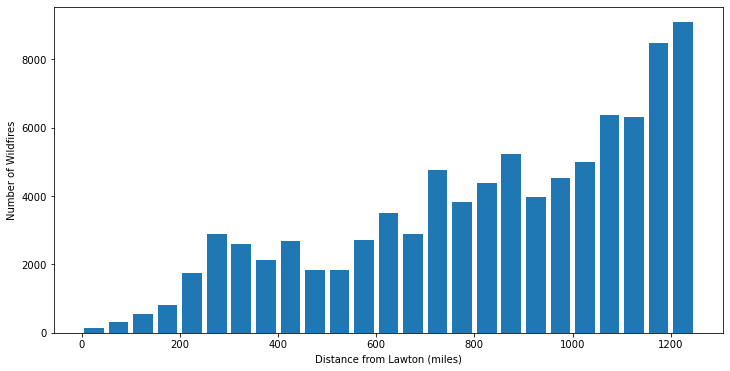

In [27]:
from matplotlib import pyplot as plt


max_distance = smoke_est_df['Distance'].max()

# Determine the number of bins by dividing the max distance by 50
num_bins = int(max_distance // 50) + (max_distance % 50 > 0)

plt.figure(figsize=(12, 6))
plt.hist(smoke_est_df['Distance'], bins=num_bins, range=(0, max_distance), rwidth=0.8)

plt.xlabel('Distance from Lawton (miles)')
plt.ylabel('Number of Wildfires')

plt.show()

## Visualization: Acres Burned by Year
Time series graph of total acres burned per year for the fires occurring in the specified distance from Lawton city.

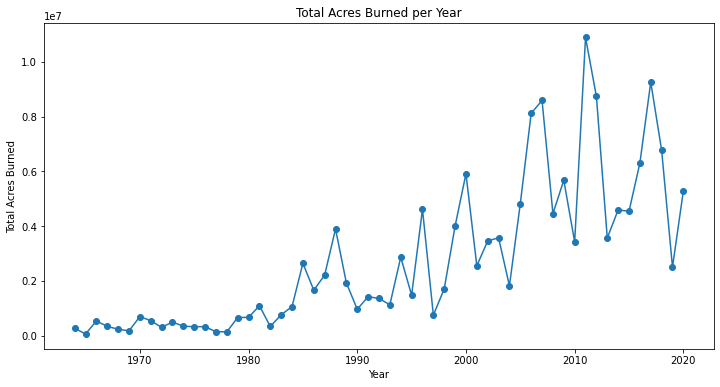

In [14]:
# Group by 'Fire_Year' and sum 'GIS_Acres' to get the total acres burned per year
acres_per_year = smoke_est_df.groupby('Fire_Year')['GIS_Acres'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(acres_per_year['Fire_Year'], acres_per_year['GIS_Acres'], marker='o')

plt.title('Total Acres Burned per Year')
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')

plt.show()

## Visualization: Compare Smoke Estimate with AQI
Time series graph containing your fire smoke estimate for your city and the AQI estimate for Lawton city.

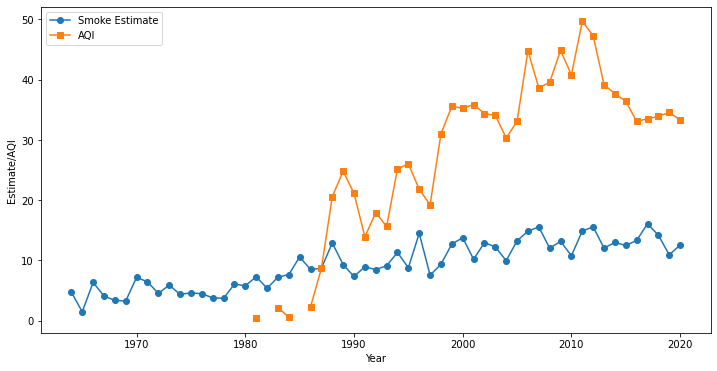

In [18]:
aqi_df = pd.read_csv('yearly_aqi.csv')


smoke_df = smoke_est_df.groupby('Fire_Year')['scaled_smoke_est'].mean().reset_index()

df_merged = pd.merge(smoke_df, aqi_df, how='left', left_on='Fire_Year', right_on='year')

plt.figure(figsize=(12, 6))

plt.plot(df_merged['Fire_Year'], df_merged['scaled_smoke_est'], label='Smoke Estimate', marker='o')
plt.plot(df_merged['Fire_Year'], df_merged['aqi'], label='AQI', marker='s')


plt.xlabel('Year')
plt.ylabel('Estimate/AQI')

plt.legend()
plt.show()